<h1>FIGURE 4<span class="tocSkip"></span></h1>

###### Comparison of spike-timing dependent synaptic plasticity with rate-based synaptic plasticity

<h1>Contents<span class="tocSkip"></span></h1>
<br>
<div class="toc"><ul class="toc-item"><li><span><a href="#Unified-estimator" data-toc-modified-id="Unified-estimator-1">Unified estimator</a></span><ul class="toc-item"><li><ul class="toc-item"><li><span><a href="#Compute-coefficients-for-the-third-best-unified-estimator-(Eq.-24)" data-toc-modified-id="Compute-coefficients-for-the-third-best-unified-estimator-(Eq.-24)-1.0.1">Compute coefficients for the third best unified estimator (Eq. 24)</a></span></li></ul></li></ul></li><li><span><a href="#Population-1" data-toc-modified-id="Population-1-2">Population 1</a></span><ul class="toc-item"><li><span><a href="#LTP" data-toc-modified-id="LTP-2.1">LTP</a></span></li><li><span><a href="#LTD" data-toc-modified-id="LTD-2.2">LTD</a></span></li></ul></li><li><span><a href="#Population-2" data-toc-modified-id="Population-2-3">Population 2</a></span><ul class="toc-item"><li><span><a href="#LTP" data-toc-modified-id="LTP-3.1">LTP</a></span></li><li><span><a href="#LTD" data-toc-modified-id="LTD-3.2">LTD</a></span></li></ul></li><li><span><a href="#Population-3" data-toc-modified-id="Population-3-4">Population 3</a></span><ul class="toc-item"><li><span><a href="#No-competition" data-toc-modified-id="No-competition-4.1">No competition</a></span></li><li><span><a href="#Strong-competition" data-toc-modified-id="Strong-competition-4.2">Strong competition</a></span></li></ul></li></ul></div>

In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib notebook

import numpy as np
import numba as nb
import matplotlib.pyplot as plt

import cbsp

cbsp.set_simulation_time(120.0)

# Unified estimator

Performs exhaustive search for the best three-feature learning rule describing rate-dependent synaptic plasticity of all populations P1, P2, P3 individually. Then, a unified score is computed by which the estimators are ranked.

In [2]:
data = dict(np.load(cbsp.data_dir / 'p1_linear_calcium.npz'))
X_p1 = cbsp.population_1.feature_matrix(data['u'], data['v'], data['w'])
rbp_p1 = data['y'].flatten()
weights_p1 = data['weights'].flatten()
es_p1 = cbsp.validation.ExhaustiveSearch(3)
es_p1.fit(X_p1, rbp_p1, weights_p1)

/Users/lappalainenj/cbsp/cbsp/utils.py:293: NumbaPerformanceWarning: '@' is faster on contiguous arrays, called on (array(float64, 2d, A), array(float64, 1d, C))
  b = wls(X_train, y_train, w_train, alpha=alpha)



3 best features:
	1.: ('v', 'v*w', 'u*w**2'), 0.810
	2.: ('u*v', 'u*v*w', 'u*w**2'), 0.798
	3.: ('v', 'u*w', 'v*w'), 0.798



In [3]:
data = dict(np.load(cbsp.data_dir / 'p2_linear_calcium_mat.npz'))
X_p2 = cbsp.population_2.feature_matrix(data['u'], data['v'].flatten(), data['w'])
rbp_p2 = data['y'].flatten()
weights_p2 = data['weights'].flatten()
es_p2 = cbsp.validation.ExhaustiveSearch(3)
es_p2.fit(X_p2, rbp_p2, weights_p2)


3 best features:
	1.: ('u**2', 'u*v', 'u**2*w**2'), 0.822
	2.: ('u**2', 'v**2', 'u**2*w**2'), 0.797
	3.: ('u**2', 'u*v', 'u**2*w'), 0.786



In [4]:
data = dict(np.load(cbsp.data_dir / 'p3_linear_calcium_mat.npz'))
# takes each tenth datapoint to make computation a little bit cheaper
X_p3 = cbsp.population_3.feature_matrix(data['u'], data['v'].flatten(), data['w'])[::10]
rbp_p3 = data['y'].flatten()[::10]
weights_p3 = data['weights'].flatten()[::10]
es_p3 = cbsp.validation.ExhaustiveSearch(3)
es_p3.fit(X_p3, rbp_p3, weights_p3)


3 best features:
	1.: ('u**2', 'u**2*v', 'u**2*w**2'), 0.652
	2.: ('u**2', 'u*v', 'u**2*w**2'), 0.632
	3.: ('u*v', 'u*v*w', 'u*w**2'), 0.631



In [5]:
index, estimators = cbsp.utils.unified_estimator(es_p1, es_p2, es_p3)

In [6]:
# from visual analysis of predicted data, 
# we find that the third estimator is qualitatively
# describing the data most accurately (Table 5)
estimators[0:3]

[('u**2', 'u**2*v', 'u**2*w'),
 ('u**2', 'u**2*v', 'u**2*w**2'),
 ('u*v', 'u*v*w', 'u*w**2')]

### Compute coefficients for the third best unified estimator (Eq. 24)

In [7]:
estimator = ('u*v', 'u*v*w', 'u*w**2')

# we optimize the coefficients on the stacked data for populations 1, 2, and 3
rbp_stack = np.concatenate((rbp_p1, rbp_p2, rbp_p3))
X_stack = X_p1[list(estimator)].append(X_p2[list(estimator)]).append(X_p3[list(estimator)])
weights_stack = np.concatenate((weights_p1, weights_p2, weights_p3))
r, coefs, coefs_std = cbsp.utils.crossvalidate(X_stack.values, rbp_stack, weights_stack, splits=5)

In [8]:
# we only took every 10th datapoint from population 3
# therefore, the coefficients differ slightly from those reported
coefs

array([ 0.00012422, -0.00014083, -0.00118148])

# Population 1

## LTP

In [9]:
stdp, t, (u, v, I, c) = cbsp.population_1.linear_calcium(u=35, 
                                                      v=35, 
                                                      w0=0.3, 
                                                      seed=0)
rbp = cbsp.utils.sim_rbp(u, v, 0.3, 
                         estimator=estimator,  # Eq. 24
                         coefs=coefs # reported coefficients
                        )

<IPython.core.display.Javascript object>


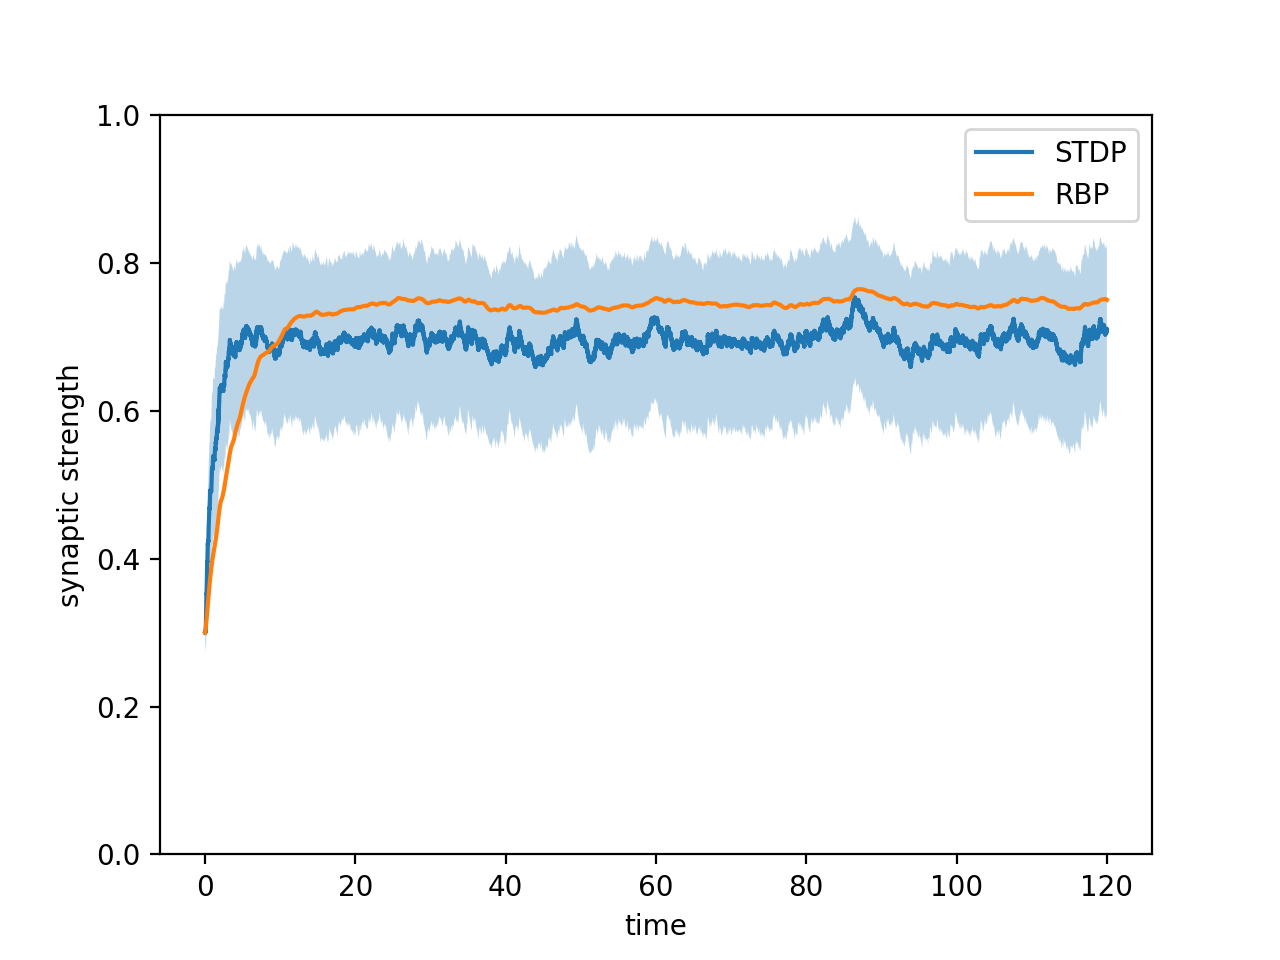

In [10]:
fig = plt.figure()
ax = plt.subplot()
cbsp.utils.trace_pop_mean_with_std(t, stdp, fig=fig, ax=ax, label="STDP")
ax.plot(t, rbp, label='RBP')
ax.set_ylim(0, 1)
ax.set_xlabel('time')
ax.set_ylabel('synaptic strength')
ax.legend()

## LTD

In [11]:
stdp, t, (u, v, I, c) = cbsp.population_1.linear_calcium(u=20, 
                                                      v=20, 
                                                      w0=0.7, 
                                                      seed=0)
rbp = cbsp.utils.sim_rbp(u, v, 0.7, 
                         estimator=estimator,  # Eq. 24
                         coefs=coefs # reported coefficients
                        )

<IPython.core.display.Javascript object>


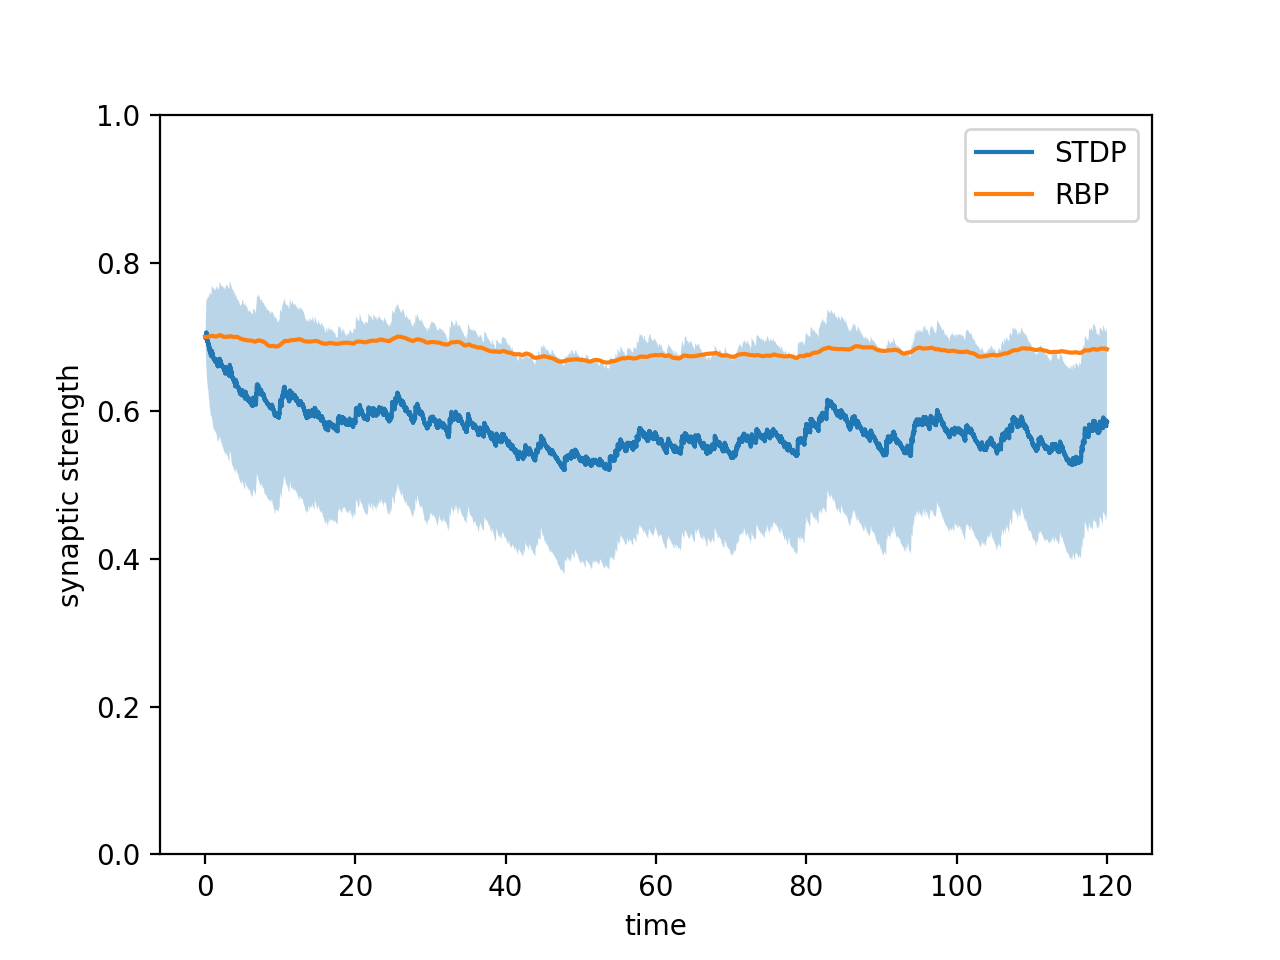

In [12]:
fig = plt.figure()
ax = plt.subplot()
cbsp.utils.trace_pop_mean_with_std(t, stdp, fig=fig, ax=ax, label="STDP")
ax.plot(t, rbp, label='RBP')
ax.set_ylim(0, 1)
ax.set_xlabel('time')
ax.set_ylabel('synaptic strength')
ax.legend()

# Population 2

## LTP

In [13]:
stdp, t, (u, v, I, c) = cbsp.population_2.linear_calcium_mat(u=65, 
                                                              w0=0.3, 
                                                              seed=0)
rbp = cbsp.utils.sim_rbp(u, v, 0.3, 
                         estimator=estimator,  # Eq. 24
                         coefs=coefs # reported coefficients
                        )

<IPython.core.display.Javascript object>


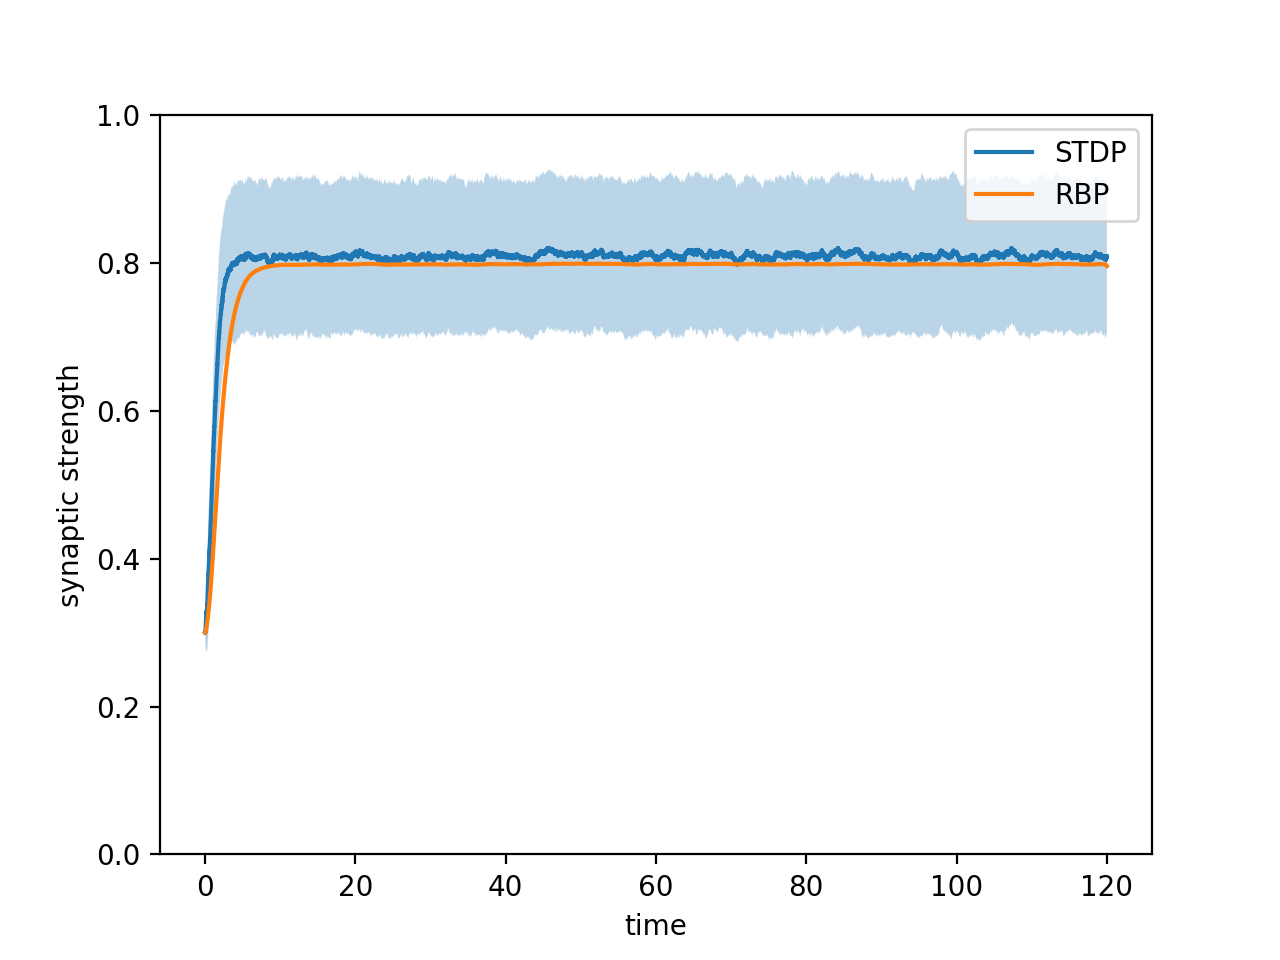

In [14]:
fig = plt.figure()
ax = plt.subplot()
cbsp.utils.trace_pop_mean_with_std(t, stdp, fig=fig, ax=ax, label="STDP")
ax.plot(t, rbp, label='RBP')
ax.set_ylim(0, 1)
ax.set_xlabel('time')
ax.set_ylabel('synaptic strength')
ax.legend()

## LTD

In [15]:
stdp, t, (u, v, I, c) = cbsp.population_2.linear_calcium_mat(u=36, 
                                                              w0=0.9, 
                                                              seed=0)
rbp = cbsp.utils.sim_rbp(u, v, 0.9, 
                         estimator=estimator,  # Eq. 24
                         coefs=coefs # reported coefficients
                        )

<IPython.core.display.Javascript object>


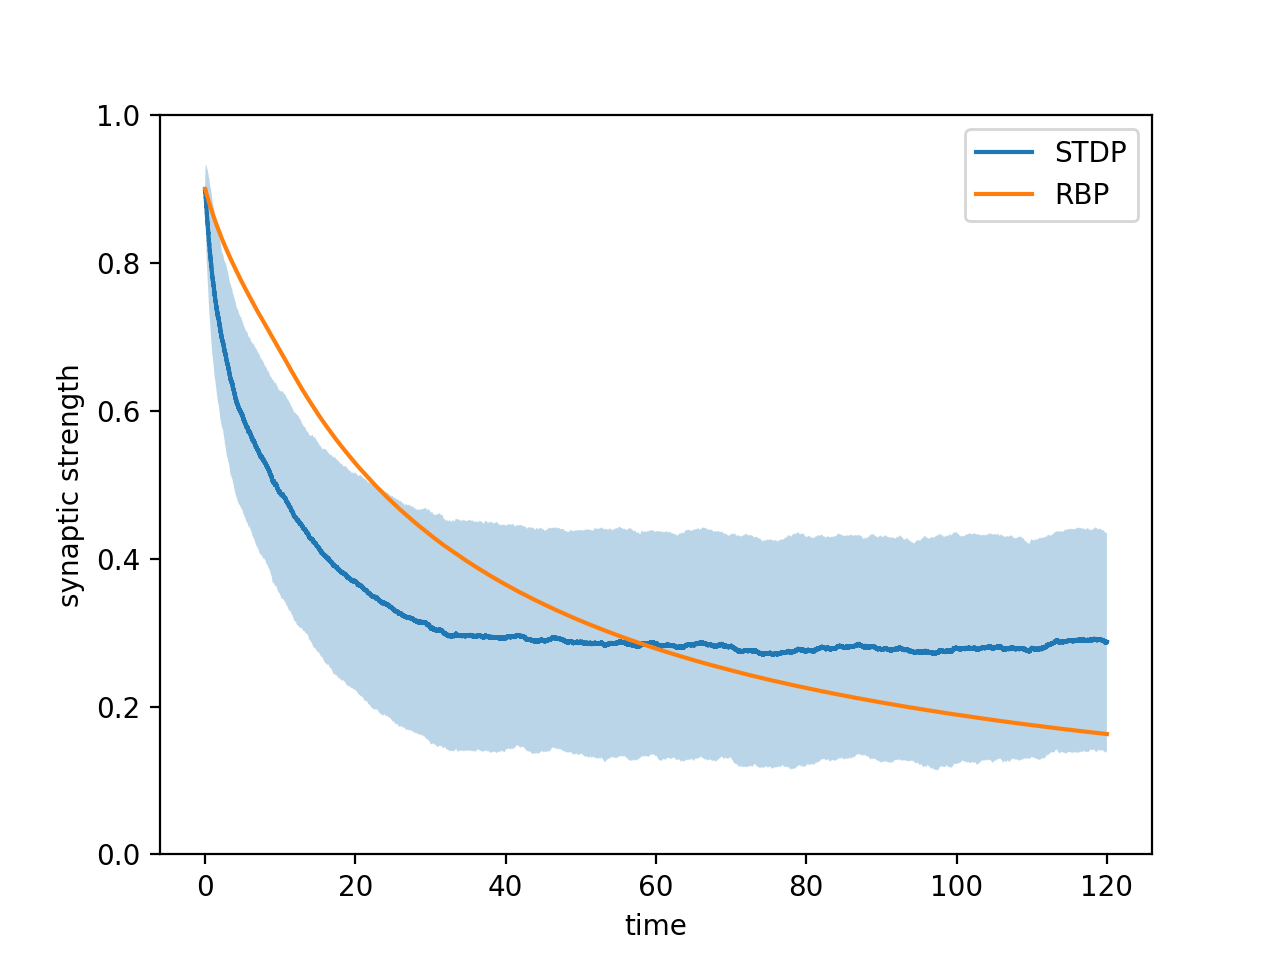

In [16]:
fig = plt.figure()
ax = plt.subplot()
cbsp.utils.trace_pop_mean_with_std(t, stdp, fig=fig, ax=ax, label="STDP")
ax.plot(t, rbp, label='RBP')
ax.set_ylim(0, 1)
ax.set_xlabel('time')
ax.set_ylabel('synaptic strength')
ax.legend()

# Population 3

In [17]:
# note, this estimator does not describe competition
estimator = ('u*v', 'u*v*w', 'u*w**2')
coefs = np.array([ 0.0001272, -0.0001444, -0.0011699])

### --- by including the feature v * w ** 2, competition is described, too
# estimator = ('u*v', 'u*v*w', 'u*w**2', 'v*w**2')
# _, coefs, _ = cbsp.utils.crossvalidate(X_p3[list(estimator)].values, rbp_p3, weights_p3, splits=5)

## No competition

In [18]:
(stdp1, stdp2), t, (u1, u2, v, _, _, _) = cbsp.population_3.linear_calcium_mat(u1=5, 
                                                                           w1=0.9,
                                                                           u2=75,
                                                                           w2=0.6,
                                                                           seed=1)
rbp1 = cbsp.utils.sim_rbp(u=u1, 
                          v=v, 
                          w0=0.9, 
                         estimator=estimator,  # Eq. 24
                         coefs=coefs # reported coefficients
                        )
rbp2 = cbsp.utils.sim_rbp(u=u2,
                          v=v, 
                          w0=0.6, 
                         estimator=estimator,  # Eq. 24
                         coefs=coefs # reported coefficients
                        )

<IPython.core.display.Javascript object>


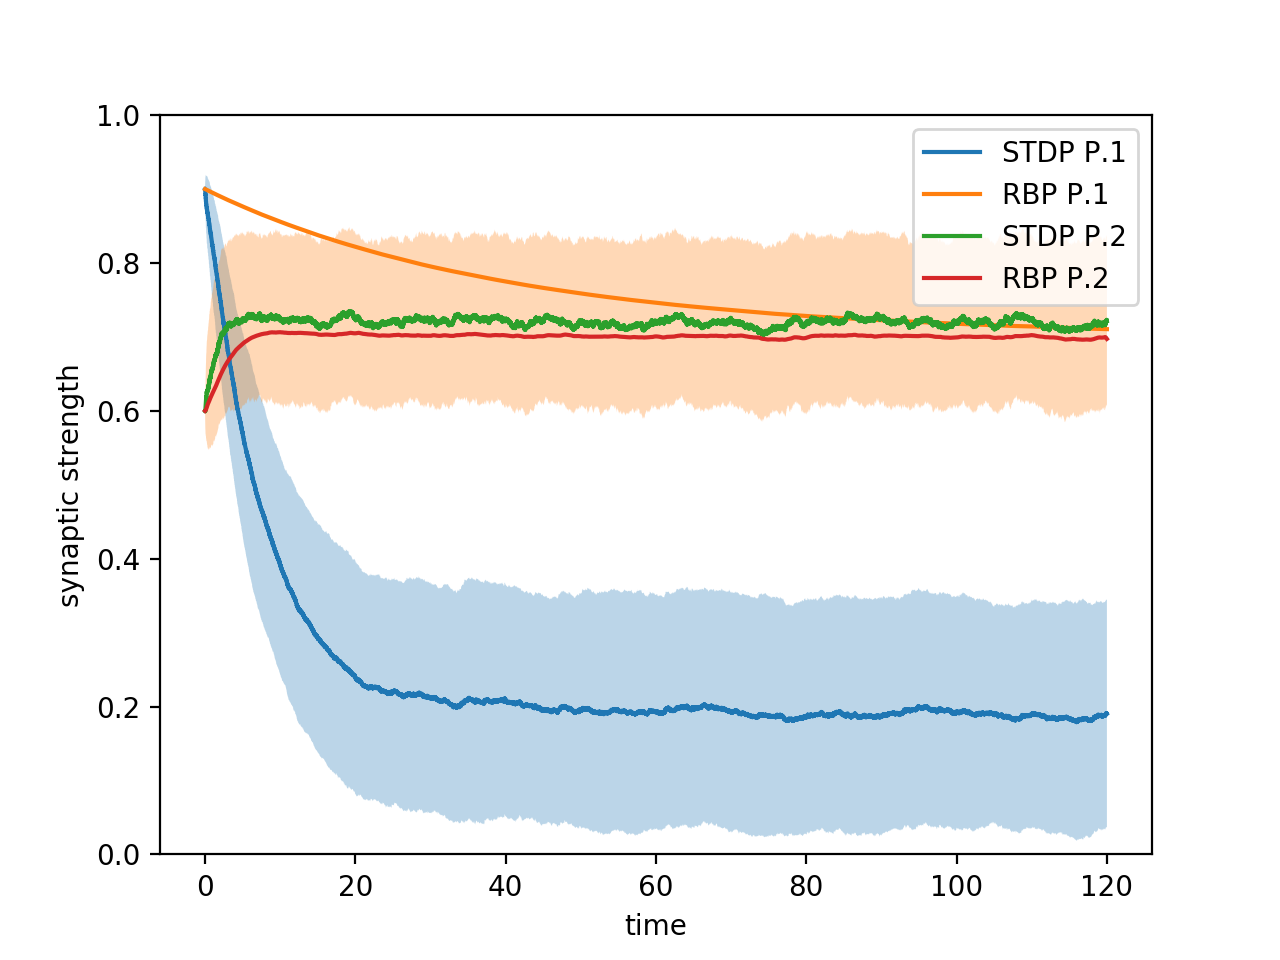

Text(0, 0.5, 'synaptic strength')

In [19]:
fig = plt.figure()
ax = plt.subplot()
cbsp.utils.trace_pop_mean_with_std(t, stdp1, label='STDP P.1', fig=fig, ax=ax)
ax.plot(t, rbp1, label='RBP P.1')
cbsp.utils.trace_pop_mean_with_std(t, stdp2, label='STDP P.2', fig=fig, ax=ax)
ax.plot(t, rbp2, label='RBP P.2')
ax.set_xlabel('time')
ax.set_ylim(0, 1)
ax.legend()
ax.set_ylabel('synaptic strength')

## Strong competition

In [20]:
(stdp1, stdp2), t, (u1, u2, v, _, _, _) = cbsp.population_3.linear_calcium_mat(u1=5, 
                                                                           w1=0.9,
                                                                           u2=90,
                                                                           w2=0.6,
                                                                           seed=1)
rbp1 = cbsp.utils.sim_rbp(u=u1,
                          v=v, 
                          w0=0.9, 
                         estimator=estimator,  # Eq. 24
                         coefs=coefs # reported coefficients
                        )
rbp2 = cbsp.utils.sim_rbp(u=u2,
                          v=v,
                          w0=0.3, 
                         estimator=estimator,  # Eq. 24
                         coefs=coefs # reported coefficients
                        )

<IPython.core.display.Javascript object>


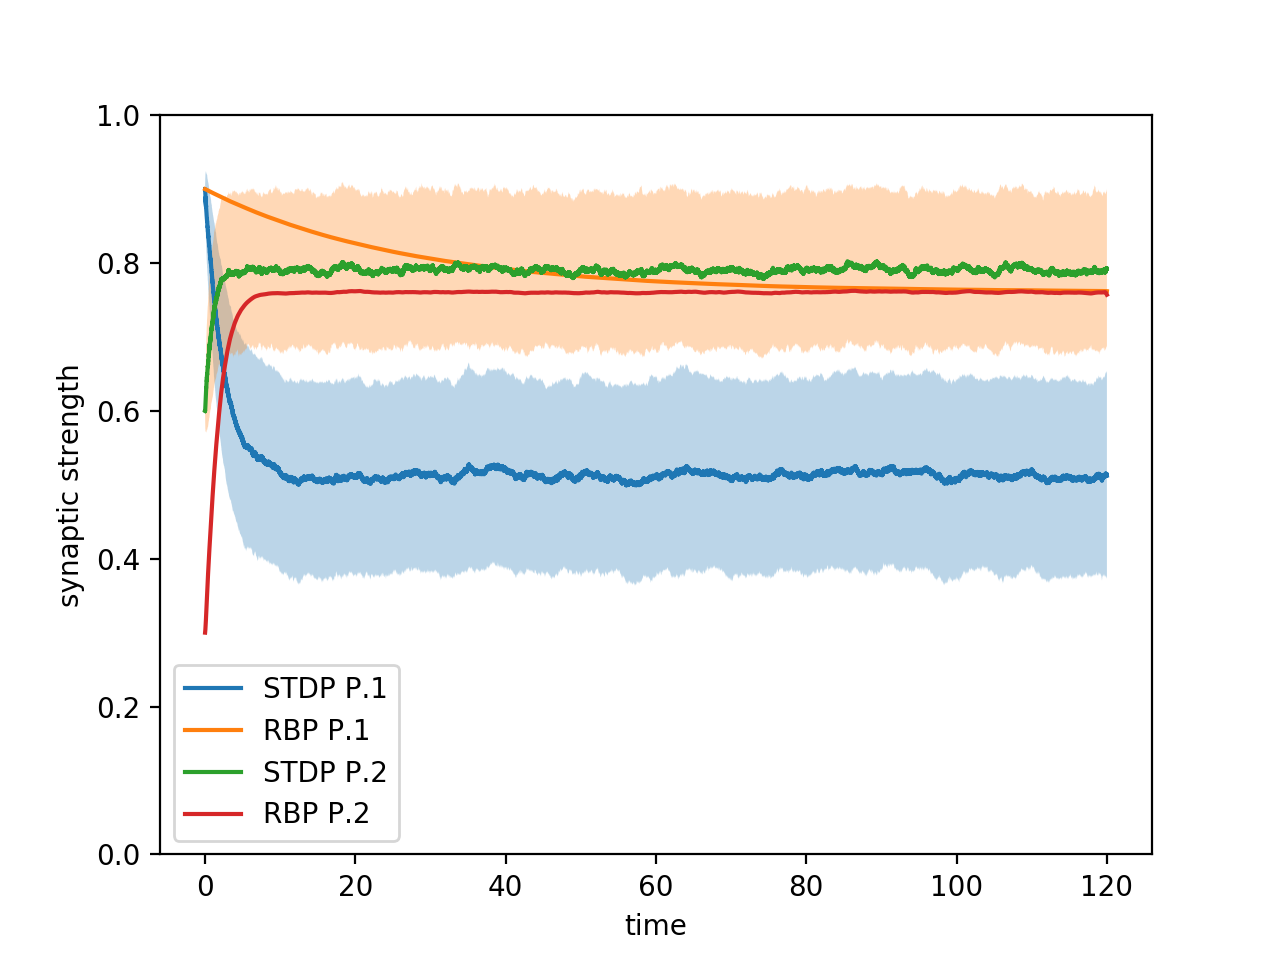

Text(0, 0.5, 'synaptic strength')

In [21]:
fig = plt.figure()
ax = plt.subplot()
cbsp.utils.trace_pop_mean_with_std(t, stdp1, label='STDP P.1', fig=fig, ax=ax)
ax.plot(t, rbp1, label='RBP P.1')
cbsp.utils.trace_pop_mean_with_std(t, stdp2, label='STDP P.2', fig=fig, ax=ax)
ax.plot(t, rbp2, label='RBP P.2')
ax.set_xlabel('time')
ax.set_ylim(0, 1)
ax.legend()
ax.set_ylabel('synaptic strength')